In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras_tuner
from kerastuner.tuners import RandomSearch
import numpy as np
import math
import pickle

C:\Users\Ananya\AppData\Local\Temp\ipykernel_22984\1930575132.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [23]:
! pip show tensorflow
! pip install --upgrade tensorflow


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\Ananya\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras


In [3]:
#loading the data
import pandas as pd


filepath = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI\\Project\One_Direction_cleaned_lyrics.parquet"
lyrics_df = pd.read_parquet(filepath)


print(lyrics_df.head())


                                        Lyrics_clean
1                you're insecure don't know what for
2  you're turnin' heads when you walk through the...
3                  don't need makeup to cover up huh
4               bein' the way that you are is enough
5               everyone else in the room can see it


In [4]:
# preprocessing the data
tokenizer_lyric = Tokenizer()
tokenizer_lyric.fit_on_texts(lyrics_df['Lyrics_clean'])
sequences = tokenizer_lyric.texts_to_sequences(lyrics_df['Lyrics_clean'])
size_vocab = len(tokenizer_lyric.word_index) + 1


In [5]:
# Creating the sequences

seq_len = 10 # sequence length
input_seq = [] # input sequences
for seq in sequences:
    for i in range(seq_len, len(seq)):
        in_seq = seq[i-seq_len: i+1]
        input_seq.append(in_seq)

input_seq = pad_sequences(input_seq, maxlen=(seq_len+1), padding='pre')
X, y = input_seq[:, :-1], input_seq[:, -1]
y = to_categorical(y,num_classes=size_vocab)



In [6]:
#defining a function to create models

def create__model(embedding_dim, lstm_units, dropout_rate, learning_rate, input_length):
    #  defining the input tensor:
    inputs = Input(shape=(input_length,))
    
    # defining the Embedding layer without the input_length in the constructor:
    x = Embedding(input_dim=size_vocab, output_dim=embedding_dim)(inputs)
    
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units)(x)
    outputs = Dense(size_vocab, activation='softmax')(x)
    
    # Creating and compiling the model:
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model







In [7]:
# model creation

models = []

config_mod = [
    (50, 100, 0.1, 0.001, seq_len),
    (100, 150, 0.2, 0.001, seq_len),
    (150, 200, 0.2, 0.0001, seq_len),
    (100, 100, 0.3, 0.001, seq_len),
    (50, 200, 0.1, 0.01, seq_len)]


In [8]:
# Training and evaluating the models

results = []

hist_list = [] 

for config in config_mod:
    try:
        model = create__model(*config)
        history = model.fit(X,y, epochs= 30, batch_size = 128, validation_split= 0.2, verbose = 2)
        hist_list.append(history)
        models.append(model)
        loss, accuracy = model.evaluate(X,y, verbose=0)
        perplexity = math.exp(loss) if loss <300 else float('inf')
        results.append((model, accuracy, perplexity, loss))
    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")



Epoch 1/30
8/8 - 4s - 438ms/step - accuracy: 0.0417 - loss: 7.3650 - val_accuracy: 0.0132 - val_loss: 7.3569
Epoch 2/30
8/8 - 0s - 27ms/step - accuracy: 0.0637 - loss: 7.2828 - val_accuracy: 0.0219 - val_loss: 7.2051
Epoch 3/30
8/8 - 0s - 26ms/step - accuracy: 0.0604 - loss: 6.5180 - val_accuracy: 0.0219 - val_loss: 6.4946
Epoch 4/30
8/8 - 0s - 26ms/step - accuracy: 0.0604 - loss: 5.4112 - val_accuracy: 0.0219 - val_loss: 6.5270
Epoch 5/30
8/8 - 0s - 26ms/step - accuracy: 0.0604 - loss: 5.1726 - val_accuracy: 0.0219 - val_loss: 6.7783
Epoch 6/30
8/8 - 0s - 26ms/step - accuracy: 0.0604 - loss: 5.1196 - val_accuracy: 0.0219 - val_loss: 6.9185
Epoch 7/30
8/8 - 0s - 26ms/step - accuracy: 0.0604 - loss: 5.0382 - val_accuracy: 0.0219 - val_loss: 6.9859
Epoch 8/30
8/8 - 0s - 27ms/step - accuracy: 0.0604 - loss: 5.0723 - val_accuracy: 0.0219 - val_loss: 7.0288
Epoch 9/30
8/8 - 0s - 26ms/step - accuracy: 0.0604 - loss: 4.9979 - val_accuracy: 0.0219 - val_loss: 7.0777
Epoch 10/30
8/8 - 0s - 26ms

Model 1 - Accuracy: 0.052677787840366364, Perplexity: 251.90661827134267, Loss: 5.529058456420898
Model 2 - Accuracy: 0.052677787840366364, Perplexity: 260.5007806299794, Loss: 5.562605857849121
Model 3 - Accuracy: 0.052677787840366364, Perplexity: 218.78492726572358, Loss: 5.388089179992676
Model 4 - Accuracy: 0.052677787840366364, Perplexity: 250.85370455330823, Loss: 5.524869918823242
Model 5 - Accuracy: 0.4591747224330902, Perplexity: 34.3308088121287, Loss: 3.536043167114258


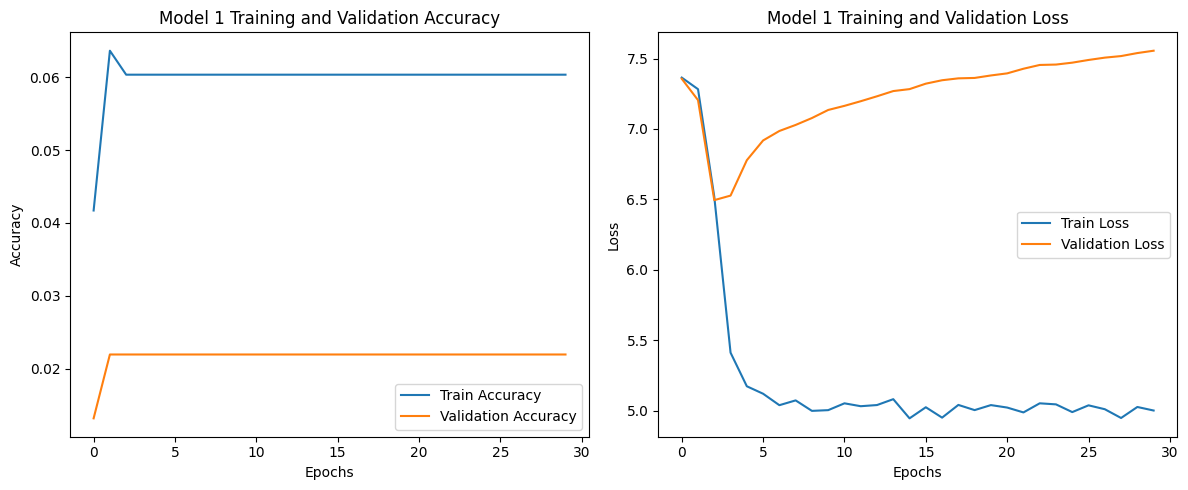

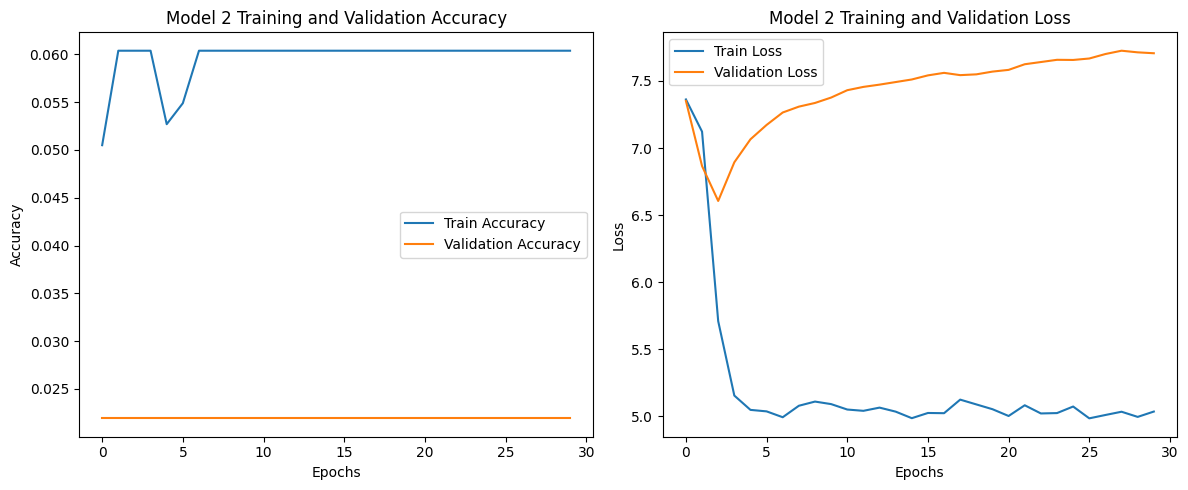

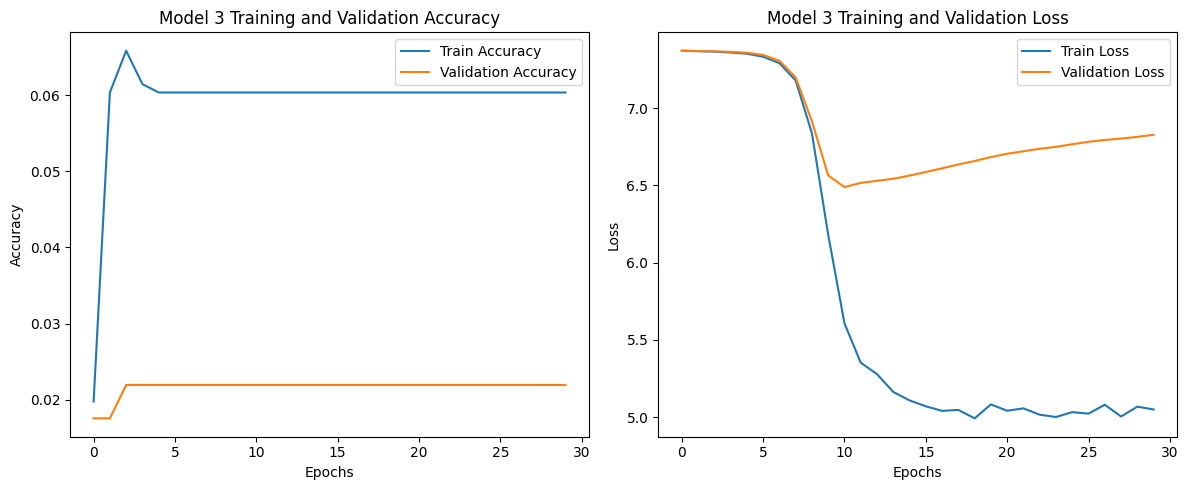

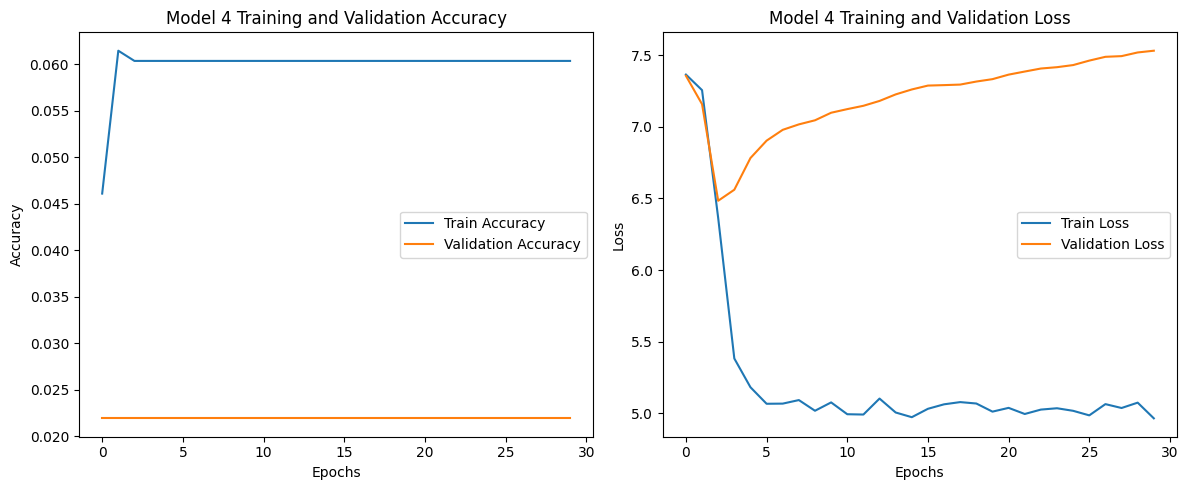

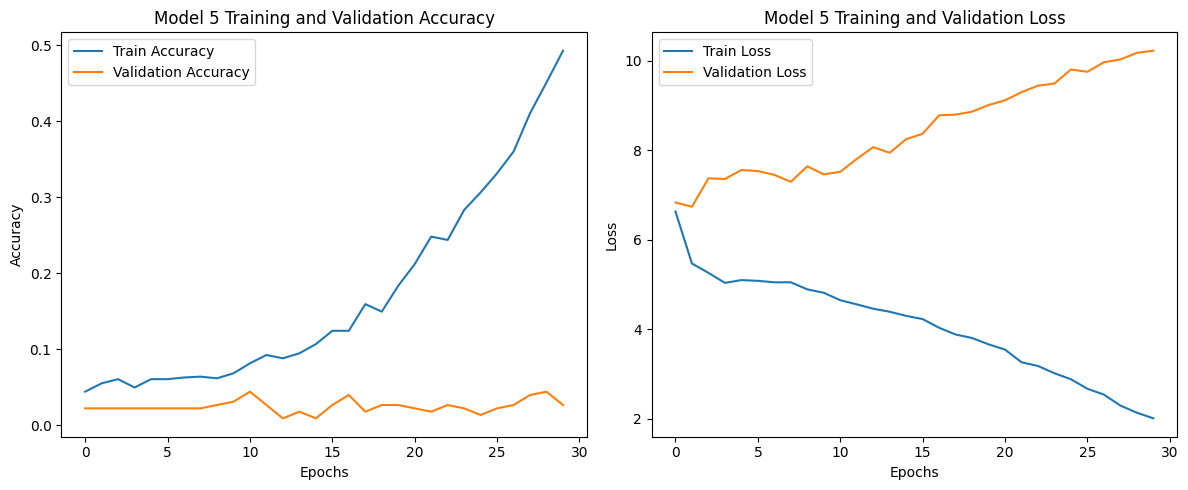

In [9]:
for idx, (model, accuracy, perplexity, loss) in enumerate(results):
    print(f"Model {idx+1} - Accuracy: {accuracy}, Perplexity: {perplexity}, Loss: {loss}")


for idx, history in enumerate(hist_list):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {idx+1} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {idx+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
#selecting the best model based on high accuracy and lowest perplexity

best__model = min(results, key = lambda item: (-item[1], item[2])) #negative accuracy for descending order 

best__model[0].save('best_1D_lyrics_generator_model.keras')

# Save the tokenizer using pickle

with open('tokenizer_lyric.pkl', 'wb') as handle:
    pickle.dump(tokenizer_lyric, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# defining a function to generate text with controlled word count

def generate__text(seed_text, min_words, max_words, model, tokenizer, max_sequence_len):
    generated_words = seed_text.split()
    while len(generated_words) < max_words:
        token_list = tokenizer.texts_to_sequences([' '.join(generated_words)])[-1]
        # Ensure padding to the exact max_sequence_len that model expects
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = predicted_probs.argmax(axis=-1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        generated_words.append(output_word)
        if len(generated_words) >= min_words and (output_word in [".", "!", "?"] or len(generated_words) == max_words):
            break
    return ' '.join(generated_words)

# Example of generating text with the improved function
print(generate__text("love you every single day", 450, 500, best__model[0], tokenizer_lyric, seq_len))




love you every single day you know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know

In [12]:
def generate__text2(seed_text, min_words, max_words, model, tokenizer, max_sequence_len):
    generated_words = seed_text.split()
    word_freq = {word: generated_words.count(word) for word in generated_words}  # Initialize word frequency dictionary

    while len(generated_words) < max_words:
        token_list = tokenizer.texts_to_sequences([' '.join(generated_words)])[-1]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = predicted_probs.argmax(axis=-1)[0]
        output_word = ""
        
        # Loop to find the next suitable word that hasn't exceeded the repetition limit
        for probability_index in predicted_probs.argsort()[0][::-1]:  # Iterate through indices of sorted probabilities
            potential_word = tokenizer.index_word[probability_index]
            if word_freq.get(potential_word, 0) < 8:
                output_word = potential_word
                word_freq[potential_word] = word_freq.get(potential_word, 0) + 1
                break

        # If no suitable word found, default to the most probable word
        if output_word == "":
            output_word = tokenizer.index_word[predicted_index]
            word_freq[output_word] = word_freq.get(output_word, 0) + 1

        generated_words.append(output_word)

        # Check if generated enough words and try to end on a punctuation if possible
        if len(generated_words) >= min_words and output_word in [".", "!", "?"]:
            break

    return ' '.join(generated_words[:max_words])

# Example of generating text with the improved function
print(generate__text2("saw you for the first time", 450, 500, best__model[0], tokenizer_lyric, seq_len))


saw you for the first time ow my heart that ooh i know it go heart you don't it better heart that my heart tonight said yeah yeah yeah yeah yeah yeah yeah yeah oh oh oh oh oh oh oh oh rock me rock me rock me rock me rock me rock me rock me rock me that i please ever woah the same ever how ooh ooh do it do it out it do it do it do it do up to night up all night up all night up all night up all night up all night up all night up all night ya go heart you said you know i know i know i know i know i know i know you go goodbye with you do olivia i'm heart love my heart tonight said tonight the heart with you with you don't olivia mind out your mind on your mind on your mind on your mind on your mind on your mind on your mind on your out get out get better one bed be the one with about the tshirt love ooh ooh ooh ooh do ya i'm tshirt better this but no the one bed be the one with about the tshirt love ooh to fix with ya beautiful infinity ever cried better edge ow my dark first this ayy ever

In [13]:
! pip install transformers


# Lyrics generation another model


In [28]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import re

# Checking the GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [29]:
#loading the vocabulary from a text 

def load_vocab(file_path):
    with open(file_path, 'r') as file:
        vocab_words = file.read().splitlines()
    return set(vocab_words)

#loading and preparing the lyrics

def loading_lyrics(file_path2):
    lyrics_df2 = pd.read_parquet(file_path2)
    return ' '.join(lyrics_df2['Lyrics_clean'].values)


In [30]:
#filtering lyrics based on the vocab set

def lyrics_filter(lyrics, vocab_set):
    filtered = ' '.join([word if word.lower() in vocab_set else '' for word in re.findall(r'\b\w+\b', lyrics)])
    return re.sub(r'\s+', ' ', filtered).strip()


# Lyrics Dataset
class LyricsDataset(Dataset):
    def __init__(self, text, seq_length):
        chars = sorted(list(set(text)))
        self.char_to_int = {ch: i for i, ch in enumerate(chars)}
        self.int_to_char = {i: ch for i, ch in enumerate(chars)}
        self.data = [self.char_to_int[ch] for ch in text]
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        return (torch.tensor(self.data[index:index+self.seq_length]),
                torch.tensor(self.data[index+1:index+self.seq_length+1]))
    

In [31]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, states):
        x = self.embedding(x)
        x, states = self.lstm(x, states)
        x = self.fc(x)
        return x, states

    def init_states(self, batch_size):
        # Adjust the state initialization to the current batch size
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda())
    

In [32]:
def train_model_plot(model, data_loader, epochs, criterion, optimizer, vocab_size, model_path):
    model.train()
    epoch_losses = []  # to store loss per epoch for plots

    for epoch in range(epochs):
        batch_losses = []  # to store loss per batch for this epoch

        # Note: No need to initialize states here, we'll do it per batch

        for batch, (x, y) in enumerate(data_loader):
            # Initialize states specifically for the current batch size
            state_h, state_c = model.init_states(x.size(0))  # Adjust state dimensions based on the batch size

            optimizer.zero_grad()
            x, y = x.cuda(), y.cuda()
            y_pred, (state_h, state_c) = model(x, (state_h.detach(), state_c.detach()))  # detach states to prevent backprop through them
            loss = criterion(y_pred.transpose(1, 2), y)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        # Average loss for this epoch
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

    # After training, plot the loss per epoch
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Saving the model state
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

    

In [44]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs, _ = model(x, model.init_states(x.size(0)))
            loss = criterion(outputs.transpose(1, 2), y)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 2)
            correct += (predicted == y).sum().item()
            total += y.numel()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def train_model_plot(model, train_loader, val_loader, epochs, criterion, optimizer, model_path):
    model.train()
    epoch_losses = []  # to store loss per epoch for plots
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        batch_losses = []  # to store loss per batch for this epoch
        model.train()

        for batch, (x, y) in enumerate(train_loader):
            state_h, state_c = model.init_states(x.size(0))  # Adjust state dimensions based on the batch size
            optimizer.zero_grad()
            x, y = x.cuda(), y.cuda()
            y_pred, (state_h, state_c) = model(x, (state_h.detach(), state_c.detach()))
            loss = criterion(y_pred.transpose(1, 2), y)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        # Average loss for this epoch
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Plotting the training and validation losses and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='r')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Saving the model state
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

In [45]:
# function to generate lyrics

def generate_lyrics(model, start_str, int_to_char, char_to_int, length, temperature=1.0):
    model.eval()
    states = model.init_states(1)
    input = torch.tensor([[char_to_int[ch] for ch in start_str]]).cuda()
    text = start_str

    for _ in range(length):
        output, states = model(input, states)
        output = output.squeeze().div(temperature).exp()
        char_id = torch.multinomial(output, 1)[-1,0].item()
        char = int_to_char[char_id]
        text += char
        input = torch.tensor([[char_id]]).cuda()
    return text

#saving the lyrics to a file

def save_lyrics(lyrics, filename):
    with open(filename, 'w') as file:
        file.write(lyrics)



In [61]:
def generate_lyrics(model, start_str, int_to_char, char_to_int, length):
    model.eval()
    states = model.init_states(1)
    input_indices = []

    # Convert start string to lowercase to match training data
    start_str = start_str.lower()

    # Convert characters to indices safely
    for ch in start_str:
        if ch in char_to_int:
            input_indices.append(char_to_int[ch])
        else:
            print(f'Character "{ch}" not in dictionary, skipping.')
            continue  # Or handle unknown character

    if not input_indices:
        print("No valid characters to process.")
        return ""

    input_tensor = torch.tensor([input_indices]).cuda()
    text = start_str

    for _ in range(length):
        output, states = model(input_tensor, states)
        output = output[:, -1, :]  # Get the last time step
        probabilities = torch.softmax(output, dim=1)
        char_id = torch.multinomial(probabilities, 1).item()
        char = int_to_char[char_id]
        text += char
        input_tensor = torch.tensor([[char_id]]).cuda()

    return text



In [46]:
# paths to files

vocab_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\The_Oxford_3000.txt"
lyrics_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\One_Direction_cleaned_lyrics.parquet"
model_save_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\lstm_model_lyrics.pth"


In [ ]:
# loading vocab and lyrics

vocab_set = load_vocab(vocab_path)
all_lyrics = loading_lyrics(lyrics_path)
all_lyrics_filt = lyrics_filter(all_lyrics, vocab_set)


In [47]:
# Dataset and DataLoader
seq_length = 100
batch_size = 64
dataset = LyricsDataset(all_lyrics_filt, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)



In [65]:
from torch.utils.data import DataLoader, random_split


total_samples = len(dataset)
val_size = int(0.1 * total_samples)  # Let's say 10% of the data for validation
train_size = total_samples - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Now create DataLoaders for both datasets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [60]:

# For Model, Loss, and Optimizer


vocab_size = len(dataset.char_to_int)
embedding_dim = 256
hidden_dim = 512
num_layers = 2
epochs = 30
learning_rate = 0.001


In [53]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Epoch 1/30, Train Loss: 0.5735, Val Loss: 0.1413, Val Acc: 0.9566
Epoch 2/30, Train Loss: 0.1285, Val Loss: 0.1227, Val Acc: 0.9601
Epoch 3/30, Train Loss: 0.1162, Val Loss: 0.1174, Val Acc: 0.9613
Epoch 4/30, Train Loss: 0.1107, Val Loss: 0.1144, Val Acc: 0.9621
Epoch 5/30, Train Loss: 0.1075, Val Loss: 0.1133, Val Acc: 0.9623
Epoch 6/30, Train Loss: 0.1053, Val Loss: 0.1113, Val Acc: 0.9628
Epoch 7/30, Train Loss: 0.1035, Val Loss: 0.1102, Val Acc: 0.9630
Epoch 8/30, Train Loss: 0.1023, Val Loss: 0.1094, Val Acc: 0.9631
Epoch 9/30, Train Loss: 0.1010, Val Loss: 0.1083, Val Acc: 0.9633
Epoch 10/30, Train Loss: 0.1002, Val Loss: 0.1087, Val Acc: 0.9633
Epoch 11/30, Train Loss: 0.0992, Val Loss: 0.1074, Val Acc: 0.9637
Epoch 12/30, Train Loss: 0.0987, Val Loss: 0.1081, Val Acc: 0.9632
Epoch 13/30, Train Loss: 0.0983, Val Loss: 0.1065, Val Acc: 0.9637
Epoch 14/30, Train Loss: 0.0975, Val Loss: 0.1070, Val Acc: 0.9636
Epoch 15/30, Train Loss: 0.0971, Val Loss: 0.1068, Val Acc: 0.9637
Epoc

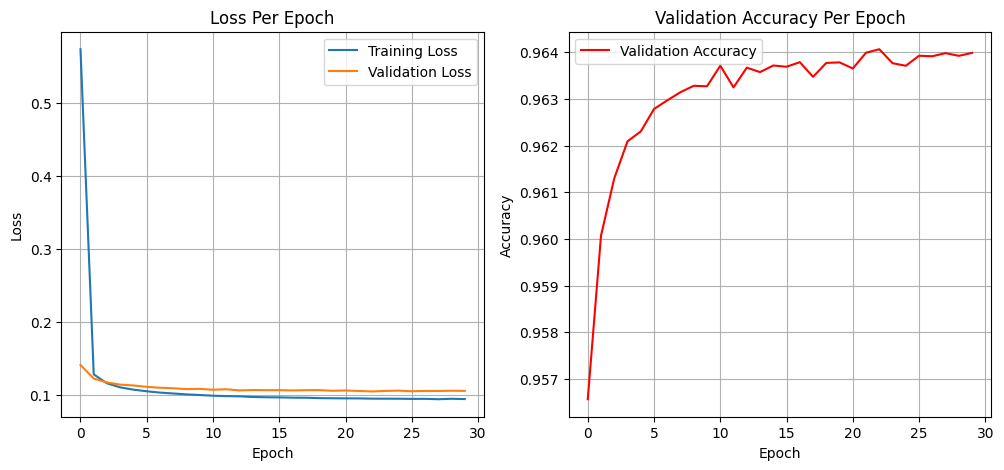

Model saved to C:\Users\Ananya\anaconda3\Dissertation - UL\Music-Generation-with-AI-1\Project\lstm_model_lyrics.pth


In [54]:
# Train the model and plot loss
train_model_plot(model, train_dataloader, val_dataloader, epochs, criterion, optimizer, model_save_path)


In [91]:
# Generate new lyrics
start_str = "when I first saw you"

generated_lyrics = generate_lyrics(model, start_str, dataset.int_to_char, dataset.char_to_int, 400)
print(generated_lyrics)

when i first saw you free so any time you think that your heart sink you know it and back all back all one to make your heart remember me so any time you listen to my voice and sing along you help me my mind keep the you leave this all behind thought we strong thought we on we no they teach this in school now my heart and know what to you and me whole lot of history oh we could be the team that the world ever so let 


In [92]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length):
    # Generate extended lyrics from the model
    extended_lyrics = generate_lyrics(model, start_str, int_to_char, char_to_int, total_length)
    
    # Split the generated lyrics into words
    words = extended_lyrics.split()
    
    # Names of the artists
    names = ["Harry", "Niall", "Louis", "Zayn", "Liam"]
    np.random.shuffle(names)  # Shuffle to randomize the order each time

    # Calculate roughly equal parts for each name, but it can vary as total_length is not always a multiple of 5
    part_length = len(words) // len(names)
    parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
    
    # Handle the last few words that may have been left out due to integer division
    leftover = len(words) % len(names)
    if leftover:
        parts[-1].extend(words[-part_length - leftover:])

    # Assign each part to a name and format it
    lyrics_with_names = []
    for name, part in zip(names, parts):
        part_text = ' '.join(part)
        lyrics_with_names.append(f"{name}: {part_text}")

    return "\n\n".join(lyrics_with_names)

# sample usage within  main function or another appropriate section of your code

    # Assuming model and other components are already initialized and loaded appropriately
user_input = input("Enter the starting words of the song: ")
final_lyrics = generate_and_distribute_lyrics(model, user_input, dataset.int_to_char, dataset.char_to_int, 1000)
print(final_lyrics)


Character "," not in dictionary, skipping.
Harry: when i first saw you, from the start the start like this with tight yeah then my kiss your tonight pray that you will see the light that from the above and say cause love you more than this yeah when he his

Louis: arms and you tonight you tonight cause love you more than this yeah yeah when he you down might just die inside broken shut the door turn the light off be with you feel your love lay beside you cannot hide this even

Zayn: though try heart time me touch skin it this and the stream down my face if we could only have this life for one more day if we could only turn back time you know be your life your voice your reason to

Niall: be my love my heart breathing for this breathing for this moment in time find the to say to say before you leave me today yeah he your hand die little watch your and in why you look at me like that when

Liam: you walk by try to say it but then freeze and never it my tongue the get hear the beat of my 

In [93]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length):
    # Generate extended lyrics from the model
    extended_lyrics = generate_lyrics(model, start_str, int_to_char, char_to_int, total_length)
    
    # Split the generated lyrics into words
    words = extended_lyrics.split()
    
    # Names of the artists in the specified order
    names = ["Harry", "Louis", "Zayn", "Niall", "Liam"]
    
    # Calculate roughly equal parts for each name
    part_length = len(words) // len(names)
    parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
    
    # Handle the last few words that may have been left out due to integer division
    leftover = len(words) % len(names)
    if leftover:
        parts[-1].extend(words[-part_length - leftover:])

    # Assign each part to a name and format it into paragraphs
    lyrics_with_names = []
    for name, part in zip(names, parts):
        part_text = ' '.join(part)
        formatted_text = f"{name}:\n{part_text}\n\n"
        lyrics_with_names.append(formatted_text)

    return "".join(lyrics_with_names)


   
user_input = input("Enter the starting words of the song: ")
final_lyrics = generate_and_distribute_lyrics(model, user_input, dataset.int_to_char, dataset.char_to_int, 500)
print(final_lyrics)


Harry:
you came into my life you that one thing get out get out get out of my head so get out get out

Louis:
get out of my head get out get out get out of my head yeah and fall into my arms instead instead but

Zayn:
need that one thing need that one thing so get out get out get out of my mind out of my mind we

Niall:
bit of you take me to the edge then you hit the say it over one day but then back you to stay

Liam:
we could understand yeah know there nothing to change it but there something that be my heart already baby go on twist the we could understand yeah know there nothing to change it but there something that be my heart already baby go on twist the knife one mo




In [ ]:
wors = 1000


Harry:
when i first saw you, from the start the start like this with tight yeah then my kiss your tonight 
pray that you will see the light that from the above and say cause love you more than this yeah when he his

Louis: 
arms and you tonight you tonight cause love you more than this yeah yeah 
when he you down might just die inside broken shut the door turn the light off be with you 
feel your love lay beside you cannot hide this even

Zayn: 
though try heart time me touch skin it this and the stream down my face if we could only have this life for one more day 
if we could only turn back time you know be your life your voice your reason to

Niall: 
be my love my heart breathing for this breathing for this moment in time find the to say to say before you 
leave me today yeah he your hand die little watch your and in why you look at me like that when

Liam: 
you walk by try to say it but then freeze and never it my tongue the get hear the beat of my heart
whenever near you but see you with him slow me apart cause you see whenever you kiss him oh how


#### improving the model


In [64]:
# expanding model complexity

class LSTMModel2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, states):
        x = self.embedding(x)
        x, states = self.lstm(x, states)
        x = self.fc(x)
        return x, states


In [75]:
class LSTMModel2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate=0.5):
        super(LSTMModel2, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Adding dropout to LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, states):
        x = self.embedding(x)
        x, states = self.lstm(x, states)
        x = self.fc(x)
        return x, states

    def init_states(self, batch_size):
        # Ensure to use .cuda() if using GPU
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda())

In [76]:
def evaluate_model2(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs, _ = model(x, model.init_states(x.size(0)))
            loss = criterion(outputs.transpose(1, 2), y)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 2)
            correct += (predicted == y).sum().item()
            total += y.numel()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy



In [ ]:
for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            ...
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # gradient clipping
            optimizer.step()
        ...
        scheduler.step()  # Adjust learning rate

In [86]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_

def train_model_with_teacher_forcing(model, train_loader, val_loader, epochs, criterion, optimizer, model_path, teacher_forcing_ratio=0.5):
    model.train()
    epoch_losses = []
    epoch_accuracies = []  # Store training accuracy per epoch
    val_losses = []
    val_accuracies = []

    # Initialize a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


    for epoch in range(epochs):
        model.train()  # Ensure model is in training mode
        batch_losses = []
        correct = 0
        total = 0

        for batch, (x, y) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda()
            state_h, state_c = model.init_states(x.size(0))
            optimizer.zero_grad()

            # Iterate over sequence and apply teacher forcing
            inputs, targets = x[:, :-1], x[:, 1:]
            outputs, (state_h, state_c) = model(inputs, (state_h, state_c))
            loss = criterion(outputs.transpose(1, 2), targets)

            loss.backward()
            clip_grad_norm_(model.parameters(), 1)  # Gradient clipping
            optimizer.step()
            batch_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 2)
            correct += (predicted == targets).sum().item()
            total += targets.numel()

        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        val_loss, val_accuracy = evaluate_model2(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        scheduler.step()  # Step the learning rate scheduler

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), model_path)
    print(f"Modified Model saved to {model_path}")



In [ ]:

# adjusting the training


import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model2(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs, _ = model(x, model.init_states(x.size(0)))
            loss = criterion(outputs.transpose(1, 2), y)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 2)  # Ensure you're using .data to avoid autograd tracking history
            correct += (predicted == y).sum().item()
            total += y.numel()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def train_model_plot2(model, train_loader, val_loader, epochs, criterion, optimizer, model_path, teacher_forcing_ratio=0.5):
    model.train()
    epoch_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        batch_losses = []
        model.train()

        for batch, (x, y) in enumerate(train_loader):
            state_h, state_c = model.init_states(x.size(0))
            optimizer.zero_grad()
            x, y = x.cuda(), y.cuda()
            outputs, (state_h, state_c) = model(x, (state_h, state_c))

            # Apply teacher forcing randomly
            if np.random.rand() < teacher_forcing_ratio:
                loss = 0
                for i in range(y.shape[1] - 1):  # Iterate through sequence length - 1
                    output, (state_h, state_c) = model(y[:, i:i+1], (state_h, state_c))
                    loss += criterion(output.squeeze(1), y[:, i+1])
            else:
                loss = criterion(outputs.transpose(1, 2), y)

            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model2(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Plotting the training and validation losses and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='r')
    plt.title('Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Saving the model state
    torch.save(model.state_dict(), model_path)
    print(f'Modified Model saved to {model_path}')


In [87]:
vocab_size2 = len(dataset.char_to_int)  # Ensure dataset is properly defined and loaded
embedding_dim2 = 256
hidden_dim2 = 1024  # Increased hidden dimensions
num_layers2 = 3     # Increased number of layers
epochs_ = 30
learning_rate2 = 0.001
dropout_rate2 = 0.5  # Added dropout rate

# Initialize the model with dropout
model2 = LSTMModel2(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate2).cuda()

# Loss function remains the same
criterion2 = nn.CrossEntropyLoss()

# Optimizer (could experiment with different learning rates or optimizers like AdamW)
#optimizer2 = optim.Adam(model.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(model.parameters(), lr=learning_rate2, weight_decay=1e-5)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=1, gamma=0.1)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


embedding.weight tensor([[ 0.1191, -0.0173, -0.0534,  ..., -0.1926,  0.0095, -0.0704],
        [-0.4492,  1.0395,  0.1973,  ...,  0.1123,  0.4903, -0.6817],
        [-2.0993, -0.5299,  1.0059,  ...,  0.7494,  0.5118, -0.5036],
        ...,
        [ 0.9418,  0.6457,  1.8267,  ..., -0.1503, -0.2171,  0.0065],
        [-0.2729, -0.5685,  0.3349,  ...,  0.7840,  0.7826, -0.4021],
        [ 1.2129, -0.2816, -0.9302,  ..., -0.6136, -2.2986,  0.7012]],
       device='cuda:0')
lstm.weight_ih_l0 tensor([[-0.0670,  0.0092,  0.1059,  ..., -0.0037, -0.0006,  0.2252],
        [-0.2517, -0.0921,  0.0125,  ..., -0.1087,  0.0979,  0.0112],
        [-0.0138, -0.1832, -0.0122,  ...,  0.0890, -0.1176,  0.2286],
        ...,
        [-0.0677,  0.1436,  0.0936,  ..., -0.1788, -0.0788,  0.1328],
        [ 0.0241, -0.2222,  0.0364,  ...,  0.2057, -0.0168,  0.2473],
        [ 0.0604, -0.2075, -0.0036,  ...,  0.1303,  0.0011, -0.0045]],
       device='cuda:0')
lstm.weight_hh_l0 tensor([[ 0.1404,  0.0513, -0.0

In [88]:
model_save_path2 = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\modified_lstm_model_lyrics.pth"

In [89]:
train_model_with_teacher_forcing(model2, train_dataloader, val_dataloader, epochs_, criterion2, optimizer2, model_save_path2, teacher_forcing_ratio=0.5)

Epoch 1/30, Train Loss: 3.2852, Train Acc: 0.0710, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 2/30, Train Loss: 3.2852, Train Acc: 0.0711, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 3/30, Train Loss: 3.2852, Train Acc: 0.0708, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 4/30, Train Loss: 3.2852, Train Acc: 0.0710, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 5/30, Train Loss: 3.2852, Train Acc: 0.0710, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 6/30, Train Loss: 3.2852, Train Acc: 0.0709, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 7/30, Train Loss: 3.2852, Train Acc: 0.0710, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 8/30, Train Loss: 3.2852, Train Acc: 0.0710, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 9/30, Train Loss: 3.2852, Train Acc: 0.0711, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 10/30, Train Loss: 3.2852, Train Acc: 0.0708, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 11/30, Train Loss: 3.2852, Train Acc: 0.0711, Val Loss: 3.2852, Val Acc: 0.0696
Epoch 12/30, Train Loss: 3.2852, Train Acc: 0.0710, Val Loss: 3

KeyboardInterrupt: 

In [ ]:
# Train the model and plot loss
train_model_plot(model, train_dataloader, val_dataloader, epochs, criterion, optimizer, model_save_path)

In [ ]:
def train(model, data_loader, epochs, criterion, optimizer, teacher_forcing_ratio=0.5):
    model.train()
    for epoch in range(epochs):
        for x, y in data_loader:
            state_h, state_c = model.init_states(x.size(0))
            optimizer.zero_grad()
            x, y = x.cuda(), y.cuda()
            outputs, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(outputs.transpose(1, 2), y)

            if random.random() < teacher_forcing_ratio:
                # Teacher forcing: Feed the target as the next input
                for i in range(y.size(1)):
                    output, (state_h, state_c) = model(y[:, i:i+1], (state_h, state_c))
                    loss += criterion(output.squeeze(1), y[:, i+1])
            
            loss.backward()
            optimizer.step()
